In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
sys.path.append('/content/gdrive/MyDrive/Project_deep_neural_networks/in-context-learning/src')

!pip install munch

Mounted at /content/gdrive


In [2]:
from collections import OrderedDict
import re
import os


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
from munch import Munch
from models import XGBoostModel, MultipleModels, LeastSquaresModel, DecisionTreeModel, NNModel
import numpy as np

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "gdrive/MyDrive/Project_deep_neural_networks/in-context-learning/src/models"

In [3]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
6,56a4bee7-75fe-4577-abf4-71a1b8b9a09f,decision_tree_and_linear,Transformer-small,,-1,-1,20,6,4,decision_tree_and_linear
9,0f7a1f77-7eb9-4429-ac55-33c81e039c57,decision_tree_and_linear_with_labels,Transformer-small,,-1,-1,21,6,4,decision_tree_and_linear_with_labels
3,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
4,c6e5d6d1-f151-414a-8792-dbfc7d116733,decision_tree,Transformer-small,depth=4,-1,-1,20,6,4,decision_tree_standard
8,186cfccb-cd95-4866-acb7-e96bc14966a9,linear_decision_tree_and_NN,Transformer-small,"models=['linear_regression', 'updated_decision...",-1,-1,20,6,4,linear_decision_tree_and_NN
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained
7,b2907f75-3b9b-404f-8ba3-c483d9f8abd7,uniform_decision_tree_and_linear,Transformer-small,weights=uniform,-1,-1,20,6,4,uniform_decision_tree_and_linear
5,7110a35b-bb4e-4796-be75-c5fdfd072f1d,updated_decision_tree,Transformer-small,depth=4_mu=0_sigma=1_normalize=False,-1,-1,20,6,4,updated_decision_tree_standard


In [7]:
#task = "linear_regression"
#task = "sparse_linear_regression"
#task = "updated_decision_tree"
#task = "relu_2nn_regression"
#task = "decision_tree_and_linear"
task="decision_tree_and_linear_with_labels"

#for labeled task
run_id = "0f7a1f77-7eb9-4429-ac55-33c81e039c57"  # if you train more models, replace with the run_id from the table above
#for decision tree and linear
#run_id="56a4bee7-75fe-4577-abf4-71a1b8b9a09f"

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

In [ ]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

decision_tree_and_linear_with_labels 0f7a1f77-7eb9-4429-ac55-33c81e039c57


100%|██████████| 1/1 [00:00<00:00, 9822.73it/s]


KeyError: ignored

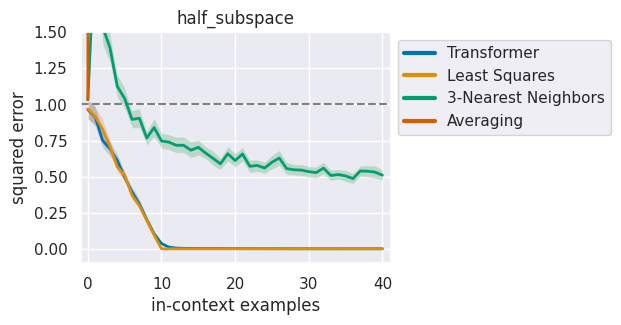

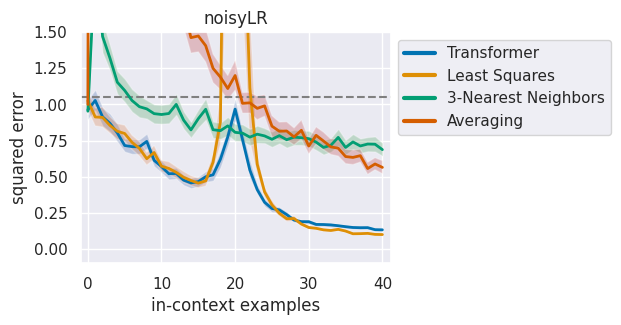

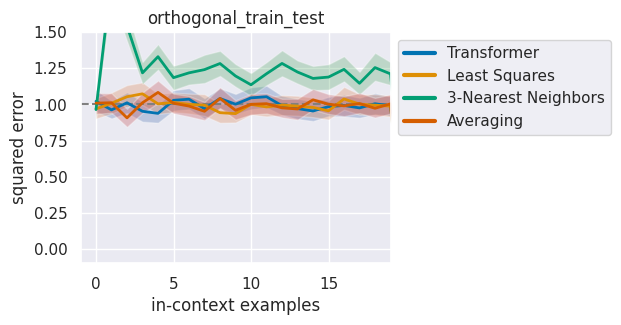

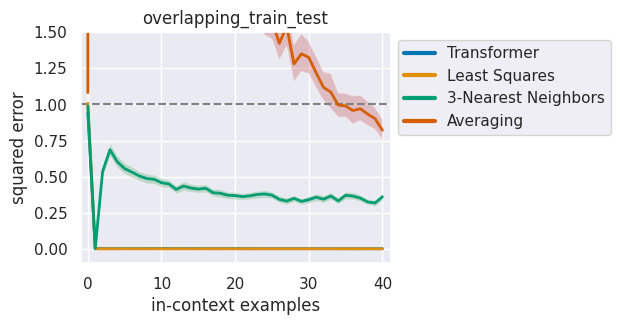

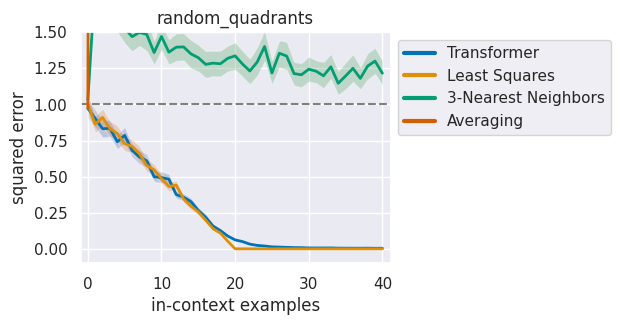

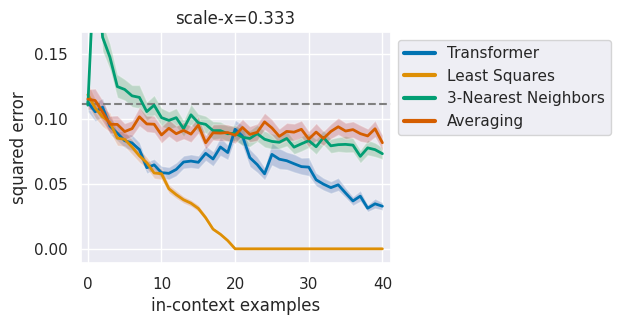

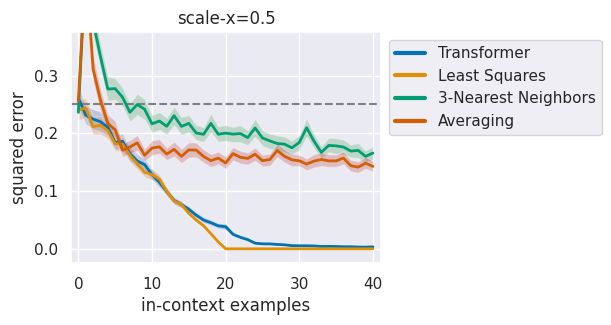

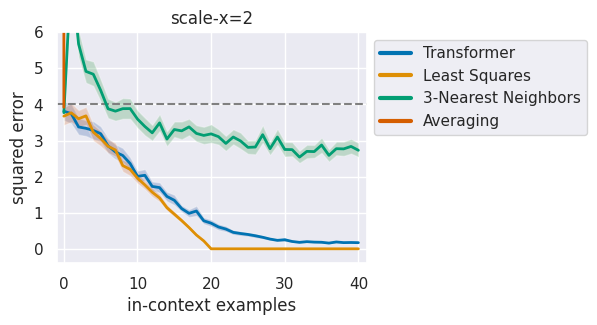

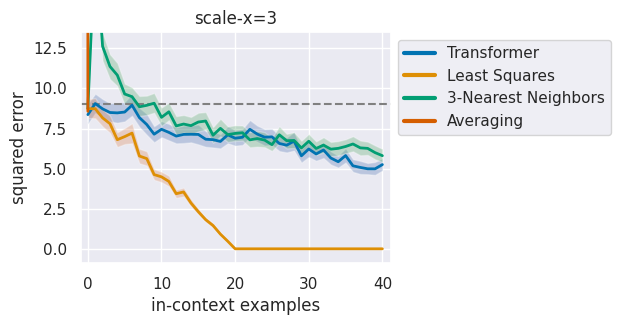

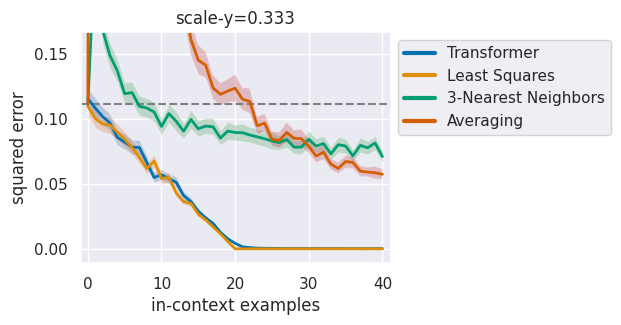

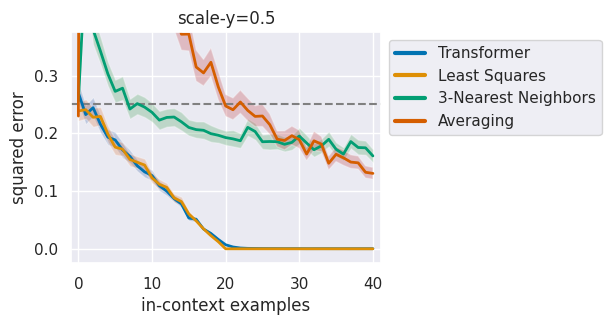

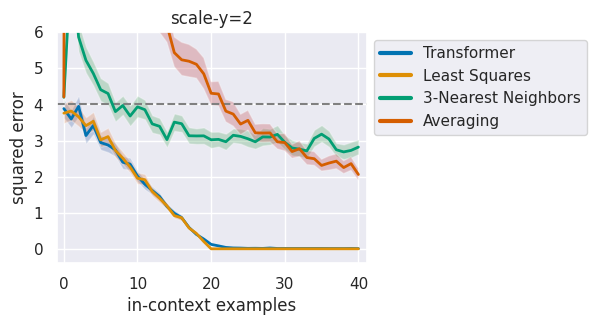

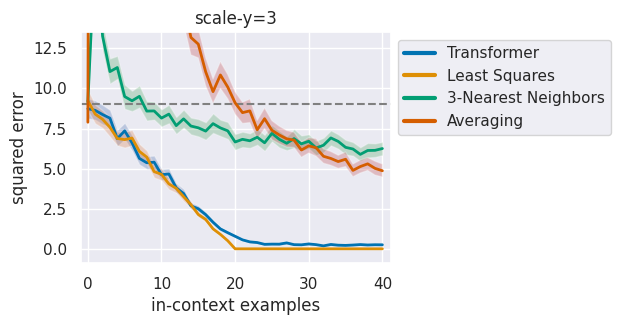

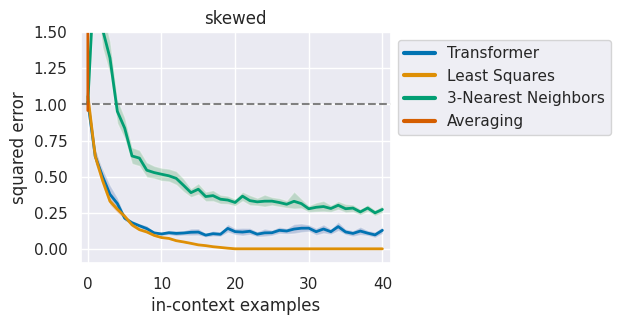

In [ ]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue

    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)

    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [4]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [5]:
model, conf = get_model_from_run(run_path)

#for tasks with labels, dims=model.dims-1
n_dims = conf.model.n_dims-1
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    #currently evaluates to {}
    **conf.training.task_kwargs
)

#remember to change the line 29 of eval if you change version of pytorch.

NameError: ignored

In [10]:
#append labels the same way the training process did, could also remove it at test time to see the results
def append_labels(xs,label):
    #xs has shape (batch_size, n_points, n_dims)
    batch_size=xs.shape[0]
    n_points=xs.shape[1]
    labels=torch.full((batch_size,n_points,1),label)
    xs_labeled=torch.concatenate((xs, labels), axis=-1)
    return xs_labeled

In [11]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
xs_labeled=append_labels(xs,task.label)
ys = task.evaluate(xs_labeled)

AttributeError: ignored

In [10]:
with torch.no_grad():
    pred = model(xs_labeled, ys)

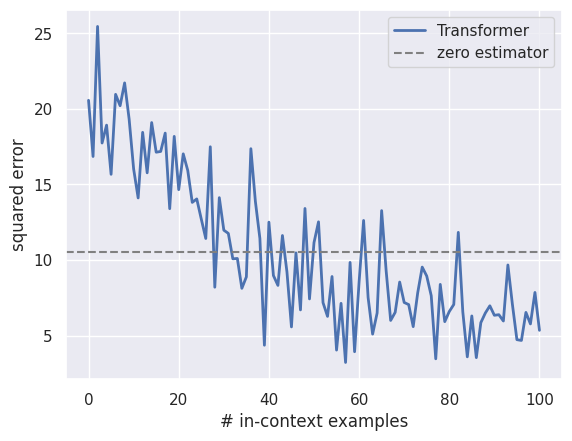

In [11]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "updated_decision_tree": 1,
    "decision_tree": 1,
    "decision_tree_and_linear": (n_dims+1)/2,
    "decision_tree_and_linear_with_labels":(n_dims+1)/2
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [ ]:
comparative_model=XGBoostModel()
with torch.no_grad():
    pred2 = comparative_model(xs, ys)

100%|██████████| 101/101 [04:47<00:00,  2.85s/it]


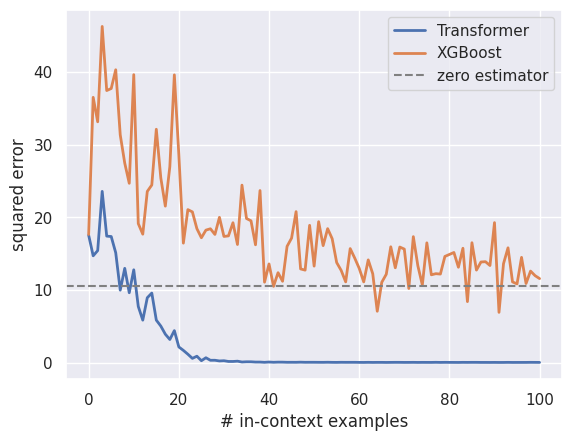

In [ ]:
loss2 = metric(pred2, ys).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0), lw=2, label="XGBoost")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

# More indepth look

We will now compute the results over multiple batches

In [12]:
model, conf = get_model_from_run(run_path)
model2, conf2=get_model_from_run(os.path.join(run_dir,"decision_tree_and_linear","56a4bee7-75fe-4577-abf4-71a1b8b9a09f"))
#not sure to use the updated dt or original dt
model3, conf3=get_model_from_run(os.path.join(run_dir, "updated_decision_tree", "7110a35b-bb4e-4796-be75-c5fdfd072f1d"))

n_dims = conf.model.n_dims-1
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_regression",
    n_dims,
    batch_size,
    **conf2.training.task_kwargs
)

print(conf)

Munch({'model': Munch({'family': 'gpt2', 'n_dims': 21, 'n_embd': 128, 'n_head': 4, 'n_layer': 6, 'n_positions': 101}), 'out_dir': 'gdrive/MyDrive/Project_deep_neural_networks/in-context-learning/src/models/decision_tree_and_linear_with_labels/0f7a1f77-7eb9-4429-ac55-33c81e039c57', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 20, 'inc': 1, 'interval': 2000, 'start': 5}), 'points': Munch({'end': 101, 'inc': 5, 'interval': 2000, 'start': 26})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'num_training_examples': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'decision_tree_and_linear_with_labels', 'task_kwargs': Munch({}), 'train_steps': 1000001}), 'wandb': Munch({'entity': 'in-context-learning-group', 'log_every_steps': 100, 'name': 'decision_tree_and_linear_with_labels', 'notes': 'run1', 'project': 'in-context-learning'})})


  0%|          | 0/20 [00:00<?, ?it/s]

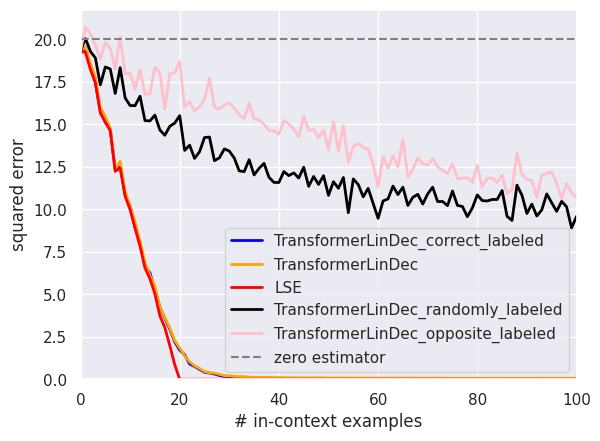

In [14]:
#may take 60 minutes to run using the GPU
import random
num_batches=20
comparative_model=LeastSquaresModel()
#comparative_model=XGBoostModel()#MultipleModels(["linear_regression", "updated_decision_tree"])
#bad_comparative_model=DecisionTreeModel() #either set this to None or to a model described in Models.py
#bad_comparative_model2=NNModel(3) #either set this to None or to a model described in Models.py
#model_type="standard" #combination, multiple or standard
use3=True #use a third model for comparision

#different losses
losses=[]
losses2=[]
losses3=[]
losses4=[]
losses5=[]
losses6=[]
losses7=[]

metric = task.get_metric()

for i in tqdm(range(num_batches)):
  task = task_sampler()
  xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
  #we could also try labels that don't correspond to decision tree
  random_label=random.randint(1,100)/100
  xs_randomly_labeled=append_labels(xs,random_label)
  xs_opposite_labeled=append_labels(xs,1)
  xs_labeled=append_labels(xs,0)
  ys = task.evaluate(xs)

  #correct labels
  with torch.no_grad():
    pred = model(xs_labeled,ys)
  loss=metric(pred,ys).numpy()
  losses.append(loss)

  #random labels during testing
  with torch.no_grad():
    pred6=model(xs_randomly_labeled,ys)
  loss6=metric(pred6,ys)
  losses6.append(loss6)

  #opposite labels
  with torch.no_grad():
    pred7=model(xs_opposite_labeled,ys)
  loss7=metric(pred7,ys)
  losses7.append(loss7)
  #decision tree and linear
  with torch.no_grad():
    pred2=model2(xs,ys)
  loss2 = metric(pred2, ys).numpy()
  losses2.append(loss2)
  '''if model_type=="standard":
    with torch.no_grad():
      pred2 = comparative_model(xs, ys)
  elif model_type=="combination":
      splitys=task.get_split_eval(xs)
      pred2=comparative_model(xs, splitys)
  elif model_type == "multiple":
      index = task.get_index()
      pred2=comparative_model(xs, ys, index)
  else:
    print("please set a valid model_type")
 '''

  #updated decision tree
  '''with torch.no_grad():
    loss3=metric(model3(xs, ys), ys).numpy()*20
  losses3.append(loss3)'''

  #LSE
  with torch.no_grad():
    loss4=metric(comparative_model(xs, ys), ys).numpy()
  losses4.append(loss4)

  #decision tree model
  #with torch.no_grad():
  #  loss5=metric(bad_comparative_model(xs, ys), ys).numpy()
  #losses5.append(loss5)


loss=np.concatenate(losses)
loss2=np.concatenate(losses2)
#loss3=np.concatenate(losses3)
loss4=np.concatenate(losses4)
#loss5=np.concatenate(losses5)
loss6=np.concatenate(losses6)
loss7=np.concatenate(losses7)

'''sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
  "linear_regression": n_dims,
  "sparse_linear_regression": sparsity,
  "relu_2nn_regression": n_dims,
  "updated_decision_tree": 1,
  "decision_tree": 1,
  "decision_tree_and_linear": (n_dims+1)/2
}[conf.training.task]'''


baseline=20

plt.plot(loss.mean(axis=0), lw=2, label="TransformerLinDec_correct_labeled",color="blue")
plt.plot(loss2.mean(axis=0), lw=2, label="TransformerLinDec",color="orange")
#plt.plot(loss3.mean(axis=0), lw=2, label="TransformerDec",color="green")
plt.plot(loss4.mean(axis=0), lw=2, label="LSE",color="red")
#plt.plot(loss5.mean(axis=0), lw=2, label="DecisionTree",color="purple")
plt.plot(loss6.mean(axis=0), lw=2, label="TransformerLinDec_randomly_labeled",color="black")
plt.plot(loss7.mean(axis=0), lw=2, label="TransformerLinDec_opposite_labeled",color="pink")


plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlim(0, 100)
plt.ylim(0)
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

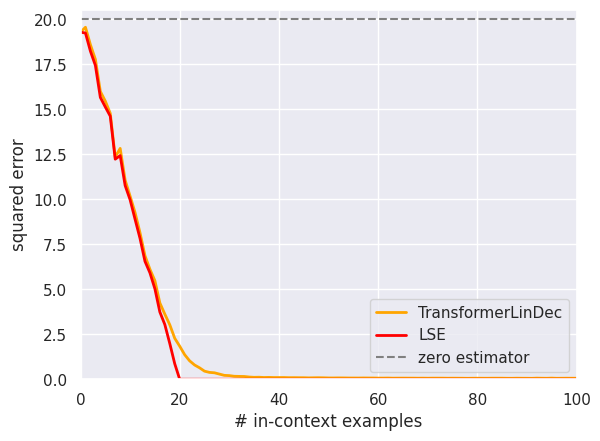

In [19]:
sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
'''baseline = {
  "linear_regression": n_dims,
  "sparse_linear_regression": sparsity,
  "relu_2nn_regression": n_dims,
  "updated_decision_tree": 1,
  "decision_tree": 1,
  "decision_tree_and_linear": (n_dims+1)/2
}[conf.training.task]'''


baseline=20

#plt.plot(loss.mean(axis=0), lw=2, label="TransformerLinDec_labeled",color="blue")
plt.plot(loss2.mean(axis=0), lw=2, label="TransformerLinDec",color="orange")
#plt.plot(loss3.mean(axis=0), lw=2, label="TransformerDec",color="green")
plt.plot(loss4.mean(axis=0), lw=2, label="LSE",color="red")
#plt.plot(loss5.mean(axis=0), lw=2, label="DecisionTree",color="purple")
#plt.plot(loss6.mean(axis=0), lw=2, label="TransformerLinDec_randomly_labeled",color="black")
#plt.plot(loss7.mean(axis=0), lw=2, label="TransformerLinDec_opposite_labeled",color="pink")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlim(0, 100)
plt.ylim(0)
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [ ]:
from models import XGBoostModel as TestModel

In [ ]:
task = "linear_regression"
#task = "sparse_linear_regression"
task = "decision_tree"
#task = "relu_2nn_regression"
#task= "updated_decision_tree"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [ ]:
model, conf = get_model_from_run(run_path)

conf.training.task_kwargs=Munch({"depth": 4}) #change the hidden layer of the model for the answers
Base2=TestModel()


n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

#remember to change the line 29 of eval if you change version of pytorch.

In [ ]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end+75)

ys = task.evaluate(xs)

In [ ]:
with torch.no_grad():
    pred = model(xs, ys)

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()
loss2=metric(Base2(xs, ys), ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0), lw=2, label="LSE")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [ ]:
#Other distribution

from eval import gen_opposite_quadrants

xs, xtest = gen_opposite_quadrants(data_sampler, n_points=conf.training.curriculum.points.end, b_size=batch_size)

print(xs[0].shape, xs[1].shape, conf.training.curriculum.points.end, batch_size)

ys = task.evaluate(xs)

In [ ]:
from tasks import DecisionTree, UpdatedDecisionTree, MultipleTask, NoisyLinearRegression, RandomForest, ConvexCombination

#tre=UpdatedDecisionTree(3, 1)

#tre=DecisionTree(3, 1)

#tre= MultipleTask(3, 1, [DecisionTree, UpdatedDecisionTree, NoisyLinearRegression], probabilities=[0.3, 0.2, 0.5])

#tre=RandomForest(3, 1)

tre=ConvexCombination(3, 1, weights="2uniform")

a=torch.randint(low=-5, high = 5, size=(1, 16, 3)).float()

print(a)

print(tre.evaluate(a))

tensor([[[ 1.,  3., -1.],
         [ 2., -3.,  3.],
         [ 2.,  4.,  3.],
         [-2.,  2.,  3.],
         [-1.,  4., -5.],
         [ 2., -4., -1.],
         [ 4.,  2., -2.],
         [-1.,  2., -4.],
         [ 0., -5., -5.],
         [ 4., -5.,  2.],
         [-3., -4.,  0.],
         [-5., -4., -2.],
         [-1.,  0.,  3.],
         [ 4., -2., -3.],
         [ 0., -4., -3.],
         [-4., -5.,  1.]]])
tensor([[ -5.5113,  12.6193,  -3.4561,  -6.3615, -14.8628,  12.8056,   1.6028,
          -9.4332,   8.0606,  20.1587,   4.2388,  -1.1633,   0.0756,  10.3089,
           7.4035,   4.3118]])
